# This notebook uses pytorch lightning & optuna & a Recurrent Attentive Neural Process for Sequential Data (RANPfSQ)

This notebook trains an Attentional Neural Network on timeseries data from smartmeters.

It uses pytorch lighting for the training loop. And Optuna for the hyperparameter optimisation.

It also pushes results to the tensorboard hyperparameter dashboard for examination.

- https://github.com/optuna/optuna/blob/master/examples/pytorch_lightning_simple.py

- similar to https://arxiv.org/abs/1910.09323

Results on *Smartmeter* prediction

|Model|val_loss|
|--|--| 
|ANP-RNN|-1.27|
|ANP-RNN_imp|-1.38|
|ANP|-1.3|
|ANP_impr|-1.2|
|NP|-1.3|

In [1]:
import sys, re, os, itertools, functools, collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
from pathlib import Path
from tqdm.auto import tqdm

import optuna
import pytorch_lightning as pl
from optuna.integration import PyTorchLightningPruningCallback


import math
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import torch.nn.functional as F

In [3]:

from neural_processes.data.smart_meter import collate_fns, SmartMeterDataSet, get_smartmeter_df
from neural_processes.plot import plot_from_loader

from neural_processes.dict_logger import DictLogger
from neural_processes.utils import PyTorchLightningPruningCallback
from neural_processes.train import main, objective, add_number, run_trial

from neural_processes.models.neural_process.lightning import PL_NP, PL_ANP, PL_ANPRNN

from neural_processes.models.transformer import PL_Transformer
from neural_processes.models.transformer_seq2seq import TransformerSeq2Seq_PL

from neural_processes.models.lstm_seqseq import LSTMSeq2Seq_PL
from neural_processes.models.lstm_std import LSTM_PL_STD

/home/wassname/.pyenv/versions/jup3.7.3/lib/python3.7/site-packages/pytorch_lightning/core/decorators.py:13: UserWarning:

data_loader decorator deprecated in 0.7.0. Will remove 0.9.0



In [4]:
# Params
device='cuda'
use_logy=False

In [5]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger("RANP.ipynb")

# Load kaggle smart meter data

In [6]:
df_train, df_val, df_test = get_smartmeter_df(
#     indir=Path('./data/smart-meters-in-london'), 
#     use_logy=False, 
#     max_files=40
)

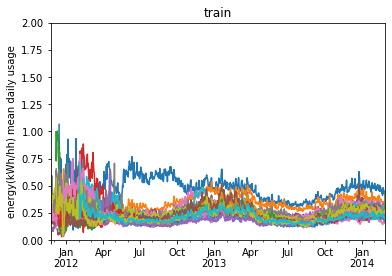

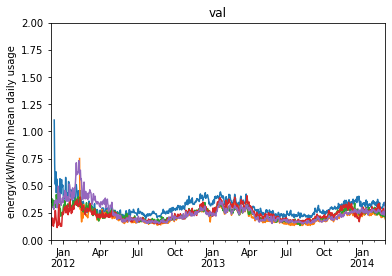

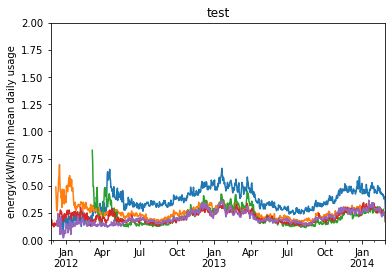

In [7]:
plt.figure()
for name,g in df_train.groupby('block'):
    g['energy(kWh/hh)'].resample('D').mean().plot(ax=plt.gca(), ylim=[0,2])
plt.title('train')
plt.ylabel('energy(kWh/hh) mean daily usage')
plt.show()

plt.figure()
for name,g in df_val.groupby('block'):
    g['energy(kWh/hh)'].resample('D').mean().plot(ax=plt.gca(), ylim=[0,2])
plt.title('val')
plt.ylabel('energy(kWh/hh) mean daily usage')
plt.show()

plt.figure()
for name,g in df_test.groupby('block'):
    g['energy(kWh/hh)'].resample('D').mean().plot(ax=plt.gca(), ylim=[0,2])
plt.title('test')
plt.ylabel('energy(kWh/hh) mean daily usage')
plt.show()

In [ ]:
# df_train[['energy(kWh/hh)']].resample('30T').mean().plot(title='train', ylim=[0,3])
# df_val[['energy(kWh/hh)']].resample('30T').mean().plot(title='val', ylim=[0,3])
# df_test[['energy(kWh/hh)']].resample('30T').mean().plot(title='test', ylim=[0,3])

# Experiments

In [ ]:
default_user_attrs = {
    'context_in_target': False,
    'x_dim': 17,
    'y_dim': 1,
    'vis_i': '670',
    'num_workers': 3,
    'num_context': 24 * 4,
    'num_extra_target': 24 * 4,
    'max_nb_epochs': 100,
    'min_std': 0.005,
    'grad_clip': 40,
    'batch_size': 32,
    'patience': 1,
    'max_epoch_steps': 16*10*400,
}
N = 5

experiments = [
    dict(name="anp-rnn",
         params={
             'det_enc_cross_attn_type': 'multihead',
             'det_enc_self_attn_type': 'multihead',
             'latent_enc_self_attn_type': 'multihead',
             'use_deterministic_path': True,
         },
         PL_MODEL_CLS=PL_ANPRNN),
    dict(name="anp-rnn_all",
         params={
             'det_enc_cross_attn_type': 'ptmultihead',
             'det_enc_self_attn_type': 'ptmultihead',
             'latent_enc_self_attn_type': 'ptmultihead',
             'use_deterministic_path': True,
             'batchnorm': True,
             'attention_dropout': 0.2,
             'dropout': 0.2,
             'use_lvar': True,
             
         },
         PL_MODEL_CLS=PL_ANPRNN),
    dict(
        name="anp-rnn_no_det",
        params={
            'use_deterministic_path': False,
        },
        PL_MODEL_CLS=PL_ANPRNN,
    ),
    dict(name="anp_c",
         PL_MODEL_CLS=PL_ANP),
    dict(
        name="np",
        PL_MODEL_CLS=PL_NP,
    ),
    dict(
        name="PL_Transformer",
        PL_MODEL_CLS=PL_Transformer,
    ),
    dict(name="TransformerSeq2Seq_PL", PL_MODEL_CLS=TransformerSeq2Seq_PL),
    dict(
        name="LSTM_PL_STD",
        PL_MODEL_CLS=LSTM_PL_STD,
    ),
    dict(
        name="LSTMSeq2Seq_PL",
        PL_MODEL_CLS=LSTMSeq2Seq_PL,
    )
]
number=-1
results = collections.defaultdict(list)

In [ ]:
# Summarize results


def summarize_results(results):
    result_dfs = []
    for k in results:
        v = results[k]
        df = pd.DataFrame(v).mean()
        df.name = k+'_mean'
        df['n'] = len(v)
        result_dfs.append(df)

        df = pd.DataFrame(v).std()
        df.name = k+'_std'
        df['n'] = len(v)
        result_dfs.append(df)

    if len(result_dfs)==0:
        return None
    result_df = pd.concat(result_dfs, 1).T
#     result_df['test_loss_p'] = result_df['test_loss_p'].fillna(100)
    return result_df.sort_values('test_loss_p').T

In [ ]:
for i in range(N):
    for exp in experiments:
        print(i, exp)
        trial, trainer, model = run_trial(
            user_attrs = default_user_attrs,
            number=number*i*100-1000,
            **exp)

        name = trainer.logger.name
        r=dict(
            **trainer.logger.metrics[-1],
            **(trainer.logger.metrics[-2] if len(trainer.logger.metrics)>1 else {})
        )
        results[name].append(r)

        display(summarize_results(results))

In [ ]:
display(summarize_results(results))

In [ ]:
# %debug

In [ ]:
display(summarize_results(results).T.sort_values(['test_loss_p']))

# Manual exp

In [ ]:
default_user_attrs = {
    'context_in_target': False,
    'x_dim': 17,
    'y_dim': 1,
    'vis_i': '670',
    'num_workers': 3,
    'num_context': 24*4,
    'num_extra_target': 24*4,
    'max_nb_epochs': 20,
    'min_std': 0.005,
    'grad_clip': 40,
    'batch_size': 16,
    'patience': 2,
    'max_epoch_steps': 6000,
}
number=None

## ANP-RNN

In [ ]:
for _ in range(N):
    trial, trainer, model = run_trial(
        name="anp-rnn",
        params={
         'det_enc_cross_attn_type': 'multihead',
         'det_enc_self_attn_type': 'uniform',
         'latent_enc_self_attn_type': 'uniform',
         'use_deterministic_path': True,
         'use_rnn': True,
         'use_lvar': False,
        },
        user_attrs = default_user_attrs,
        PL_MODEL_CLS=PL_NeuralProcess,
        number=number
    )

    name = trainer.logger.name
    results[f"{name}_{trial.number}"]=dict(
        **trainer.logger.metrics[-1],
        **(trainer.logger.metrics[-2] if len(trainer.logger.metrics)>1 else {})
    )
    results[f"{name}_{trial.number}"]

## ANP-RNN 2

In [ ]:
trial, trainer, model = run_trial(
    name="anp-rnn2",
    params={ 
        'det_enc_self_attn_type': 'multihead',
        'latent_enc_self_attn_type': 'multihead',
        'use_deterministic_path': False,
        'use_rnn': True,
        'use_lvar': False,
    },
    user_attrs=default_user_attrs,
    PL_MODEL_CLS=PL_NeuralProcess,
    number=number)

In [ ]:
name = trainer.logger.name
results[f"{name}_{trial.number}"]=dict(
    **trainer.logger.metrics[-1],
    **(trainer.logger.metrics[-2] if len(trainer.logger.metrics)>1 else {})
)
results[f"{name}_{trial.number}"]

## ANP

In [ ]:
trial, trainer, model = run_trial(name="anp_c",
                                  params={
                                      'det_enc_cross_attn_type': 'multihead',
                                      'det_enc_self_attn_type': 'multihead',
                                      'latent_enc_self_attn_type': 'multihead',
                                      'use_deterministic_path': False,
                                      'use_lvar': False,
                                  },
                                  user_attrs=default_user_attrs,
                                  PL_MODEL_CLS=PL_NeuralProcess,
                                  number=number)

In [ ]:
name = trainer.logger.name
results[f"{name}_{trial.number}"]=dict(
    **trainer.logger.metrics[-1],
    **(trainer.logger.metrics[-2] if len(trainer.logger.metrics)>1 else {})
)
results[f"{name}_{trial.number}"]

## NP

In [ ]:
trial, trainer, model = run_trial(name="np",
                                  params={
                                      'det_enc_cross_attn_type': 'uniform',
                                      'det_enc_self_attn_type': 'uniform',
                                      'latent_enc_self_attn_type': 'uniform',
                                      'use_deterministic_path': False,
                                      'use_lvar': False,
                                  },
                                  user_attrs=default_user_attrs,
                                  PL_MODEL_CLS=PL_NeuralProcess,
                                  number=number)

In [ ]:
name = trainer.logger.name
results[f"{name}_{trial.number}"]=dict(
    **trainer.logger.metrics[-1],
    **(trainer.logger.metrics[-2] if len(trainer.logger.metrics)>1 else {})
)
results[f"{name}_{trial.number}"]

## Transformer

In [ ]:
trial, trainer, model = run_trial(
    name="PL_Transformer",
    params={},
    user_attrs={
        **default_user_attrs, 'context_in_target': False
    },
    PL_MODEL_CLS=PL_Transformer,
    number=number)

In [ ]:
# %debug

In [ ]:
name = trainer.logger.name
results[f"{name}_{trial.number}"]=dict(
    **trainer.logger.metrics[-1],
    **(trainer.logger.metrics[-2] if len(trainer.logger.metrics)>1 else {})
)
results[f"{name}_{trial.number}"]

## Transformer Seq2Seq

In [ ]:
trial, trainer, model = run_trial(name="TransformerSeq2Seq_PL",
                                  params={},
                                  user_attrs=default_user_attrs,
                                  PL_MODEL_CLS=TransformerSeq2Seq_PL,
                                  number=number)

In [ ]:
name = trainer.logger.name
results[f"{name}_{trial.number}"]=dict(
    **trainer.logger.metrics[-1],
    **(trainer.logger.metrics[-2] if len(trainer.logger.metrics)>1 else {})
)
results[f"{name}_{trial.number}"]

## LSTM

In [ ]:
trial, trainer, model = run_trial(name="LSTM_PL_STD",
                                  params={},
                                  user_attrs=default_user_attrs,
                                  PL_MODEL_CLS=LSTM_PL_STD,
                                  number=number)

In [ ]:
name = trainer.logger.name
results[f"{name}_{trial.number}"]=dict(
    **trainer.logger.metrics[-1],
    **(trainer.logger.metrics[-2] if len(trainer.logger.metrics)>1 else {})
)
results[f"{name}_{trial.number}"]

## LSTM seq2seq

In [ ]:
trial, trainer, model = run_trial(name="LSTMSeq2Seq_PL",
                                  params={},
                                  user_attrs=default_user_attrs,
                                  PL_MODEL_CLS=LSTMSeq2Seq_PL,
                                  number=number)

In [ ]:
name = trainer.logger.name
results[f"{name}_{trial.number}"]=dict(
    **trainer.logger.metrics[-1],
    **(trainer.logger.metrics[-2] if len(trainer.logger.metrics)>1 else {})
)
results[f"{name}_{trial.number}"]

# Hyperparam

In [ ]:
from neural_processes.train import objective
import argparse 

In [ ]:
for PL_MODEL_CLS in [ TransformerSeq2Seq_PL, LSTM_PL_STD, LSTMSeq2Seq_PL, PL_Transformer, PL_NeuralProcess]:
    name = str(PL_MODEL_CLS.__name__)
    func = functools.partial(objective, PL_MODEL_CLS=PL_MODEL_CLS, name=name, user_attrs=default_user_attrs)
    
    

    parser = argparse.ArgumentParser(description='PyTorch Lightning example.')
    parser.add_argument('--pruning', '-p', action='store_true',
                        help='Activate the pruning feature. `MedianPruner` stops unpromising '
                             'trials at the early stages of training.')
    args = parser.parse_args(['-p'])

    pruner = optuna.pruners.MedianPruner(n_warmup_steps=1, n_startup_trials=10) if args.pruning else optuna.pruners.NopPruner()
    pruner = optuna.pruners.PercentilePruner(75.0)

    study = optuna.create_study(direction='minimize', pruner=pruner, storage=f'sqlite:///optuna_result/{name}.db', study_name=name, load_if_exists=True)

    study.optimize(func=func, n_trials=200, timeout=pd.Timedelta('3d').total_seconds())
    

    print('Number of finished trials: {}'.format(len(study.trials)))

    print('Best trial:')
    trial = study.best_trial

    print('  Value: {}'.format(trial.value))

    print('  Params: ')
    for key, value in trial.params.items():
        print('    {}: {}'.format(key, value))

    # shutil.rmtree(MODEL_DIR)
    
    df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
    print(df.sort_values('value'))

In [ ]:
df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
df.sort_values('value')

## View

TODO

In [ ]:
df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
df.sort_values('value')

In [ ]:
df.sort_values('value').head(17).T